In [1]:
import torch

from dataclasses import dataclass, field
from matplotlib import pyplot as plt
import numpy as np
import sys
from pprint import pprint
import pandas as pd

sys.path.append("../..")

# FLOPs of the mLSTM v1 & v2 blocks

In [2]:
%load_ext autoreload
%autoreload 2
from mlstm_kernels.flops_utils.mlstm_block_flop_counts import (
    count_flops_mlstm_v1_block_fw,
    count_flops_mlstm_v2_block_fw,
    FLOPsComputation,
    count_fw_flops,
)
from mlstm_kernels.flops_utils.mlstm_flop_analysis import (
    plot_mlstm_v1_v2_flop_comparison,
    make_flop_table,
)

In [3]:
S = 8192
d = 4096
Nh = 8
chunk_size = 64

In [4]:
total_flops_v1, linear_layer_flops_v1, mlstm_flops_v1 = count_flops_mlstm_v1_block_fw(
    S=S, d=d, Nh=Nh, dqk=d // Nh, dv=d // Nh, chunk_size=chunk_size
)

In [5]:
pf = 2
total_flops_v2, linear_layer_flops_v2, mlstm_flops_v2 = count_flops_mlstm_v2_block_fw(
    S=S, d=d, Nh=Nh, pf=pf, dqk=(d * pf) // Nh, dv=(d * pf) // Nh, chunk_size=chunk_size
)

In [6]:
pf = 2
_, detailed_flops = count_flops_mlstm_v2_block_fw(
    S=S,
    d=d,
    Nh=Nh,
    pf=pf,
    dqk=(d * pf) // Nh,
    dv=(d * pf) // Nh,
    chunk_size=chunk_size,
    return_detailed_flops=True,
)
detailed_flops

{'linear_layer_flops': 1649334550528,
 'qkv_proj_flops': 1610612736,
 'conv1d_flops': 671285248,
 'skip_ln_mlstm_flops': 201326592,
 'skip_ln_linear_layer_flops': 33554432,
 'mlstm_cell_total_flops': 294720542720,
 'mlstm_cell_fw_C_flops': 277496534016,
 'mlstm_cell_fw_H_flops': 17224008704}

In [7]:
print(
    f"v2 linear_layer fraction: {detailed_flops['linear_layer_flops']/total_flops_v2}"
)
print(f"v2 qkv proj fraction: {detailed_flops['qkv_proj_flops']/total_flops_v2}")
print(f"v2 conv1d fraction: {detailed_flops['conv1d_flops']/total_flops_v2}")
print(f"v2 mlstm fraction: {detailed_flops['mlstm_cell_total_flops']/total_flops_v2}")

v2 linear_layer fraction: 0.8473021592655021
v2 qkv proj fraction: 0.000827409847514833
v2 conv1d fraction: 0.0003448551053098321
v2 mlstm fraction: 0.15140491184557728


In [8]:
print(f"v1 mlstm fraction: {mlstm_flops_v1/total_flops_v1}")
print(f"v1 linear_layer fraction: {linear_layer_flops_v1/total_flops_v1}")

v1 mlstm fraction: 0.3979516024779892
v1 linear_layer fraction: 0.6020483975220108


In [9]:
print(
    f"Total FLOPS v1: {total_flops_v1/1e6}M, MLSTM FLOPS v1: {mlstm_flops_v1}, Linear Layer FLOPS v1: {linear_layer_flops_v1}"
)
print(
    f"Total FLOPS v2: {2*total_flops_v2/1e6}M, MLSTM FLOPS v2: {2*mlstm_flops_v2}, Linear Layer FLOPS v2: {2*linear_layer_flops_v2}"
)
# (2398691991552, 199500947456, 2199191044096)
# (3425595338752, 123637870592, 3298736242688)

Total FLOPS v1: 3652847.572992M, MLSTM FLOPS v1: 1453656545280, Linear Layer FLOPS v1: 2199191027712
Total FLOPS v2: 3893143.744512M, MLSTM FLOPS v2: 591186309120, Linear Layer FLOPS v2: 3298736209920


In [10]:
print(f"Total Ratio v2/v1: {(2*total_flops_v2)/total_flops_v1}")
print(f"MLSTM Ratio v2/v1: {(2*mlstm_flops_v2)/mlstm_flops_v1}")
print(f"Linear Layer Ratio v2/v1: {(2*linear_layer_flops_v2)/linear_layer_flops_v1}")

Total Ratio v2/v1: 1.0657832462807026
MLSTM Ratio v2/v1: 0.4066891254605998
Linear Layer Ratio v2/v1: 1.4999771135625029


## FLOPs vs Model size


In [ ]:
from mlstm_kernels.flops_utils.mlstm_flop_analysis import (
    get_mlstm_v1_fw_flops,
    get_mlstm_v2_fw_flops,
    get_mlstm_v1_fw_7B_flops,
    get_mlstm_v2_fw_7B_flops,
)

In [12]:
sequence_length = 8192
batch_size = 1
chunk_size = 64

In [13]:
mlstm_flops_v1 = get_mlstm_v1_fw_flops(
    sequence_length=sequence_length, batch_size=batch_size, chunk_size=chunk_size
)
mlstm_flops_v2 = get_mlstm_v2_fw_flops(
    sequence_length=sequence_length, batch_size=batch_size, chunk_size=chunk_size
)

In [14]:
(
    mlstm_flops_v1["7B"].total_flops,
    mlstm_flops_v1["7B"].mlstm_other_flops,
    mlstm_flops_v1["7B"].linear_layer_flops,
)

(3652667018240, 1453610208256, 2199056809984)

In [15]:
(
    mlstm_flops_v2["7B"].total_flops,
    mlstm_flops_v2["7B"].mlstm_other_flops,
    mlstm_flops_v2["7B"].linear_layer_flops,
)

(3892849743872, 591026526208, 3298601992192)

In [16]:
model_size_keys = list(mlstm_flops_v1.keys())

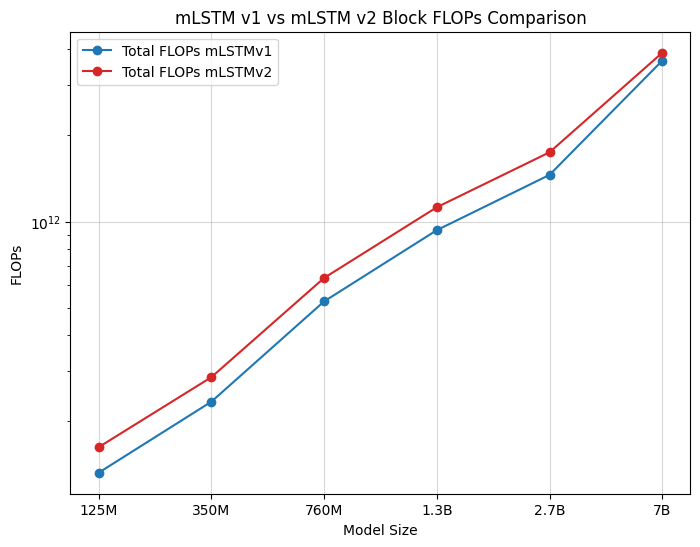

In [17]:
fig = plot_mlstm_v1_v2_flop_comparison(
    sequence_length=8192, batch_size=1, chunk_size=64, model_size_keys=model_size_keys
)

In [18]:
mlstm_flops_v1 = get_mlstm_v1_fw_flops(
    sequence_length=sequence_length, batch_size=batch_size, chunk_size=chunk_size
)
mlstm_flops_v2 = get_mlstm_v2_fw_flops(
    sequence_length=sequence_length, batch_size=batch_size, chunk_size=chunk_size
)
make_flop_table(
    mlstm_flops_v1=mlstm_flops_v1,
    mlstm_flops_v2=mlstm_flops_v2,
    model_size_keys=model_size_keys,
)

,Model Size,Total FLOPs v1,Total FLOPs v2,v2/v1 Ratio,v1 Linear Layer FLOPs Ratio,v2 Linear Layer FLOPs Ratio,v1 MLSTM Other FLOPs Ratio,v2 MLSTM Other FLOPs Ratio
0,125M,132281222656,162490133504,1.228369,0.584480,0.713746,0.415520,0.282537
1,350M,234368517632,285496642560,1.218153,0.586458,0.722163,0.413542,0.275016
2,760M,525541361152,634790202368,1.207879,0.588441,0.730764,0.411559,0.267333
3,1.3B,932711876096,1121791151104,1.202720,0.589435,0.735134,0.410565,0.263430
4,2.7B,1455880062464,1746499488768,1.199618,0.590031,0.737780,0.409969,0.261067
5,7B,3652667018240,3892849743872,1.065755,0.602041,0.847349,0.397959,0.151824


In [19]:
mlstm_flops_v1_7B = get_mlstm_v1_fw_7B_flops(
    sequence_length=sequence_length, batch_size=batch_size, chunk_size=chunk_size
)
mlstm_flops_v2_7B = get_mlstm_v2_fw_7B_flops(
    sequence_length=sequence_length, batch_size=batch_size, chunk_size=chunk_size
)
make_flop_table(
    mlstm_flops_v1=mlstm_flops_v1_7B,
    mlstm_flops_v2=mlstm_flops_v2_7B,
    model_size_keys=mlstm_flops_v1_7B.keys(),
)

,Model Size,Total FLOPs v1,Total FLOPs v2,v2/v1 Ratio,v1 Linear Layer FLOPs Ratio,v2 Linear Layer FLOPs Ratio,v1 MLSTM Other FLOPs Ratio,v2 MLSTM Other FLOPs Ratio
0,7B_nh1,4136494199168,7771149755136,1.878680,0.531623,0.424468,0.468377,0.575118
1,7B_nh2,3859606987520,5554954552832,1.439254,0.569762,0.593813,0.430238,0.405608
2,7B_nh4,3721370650112,4446868835328,1.194955,0.590927,0.741781,0.409073,0.257495
3,7B_nh8,3652667018240,3892849743872,1.065755,0.602041,0.847349,0.397959,0.151824
4,7B_nh16,3619144275968,3615887732736,0.999100,0.607618,0.912252,0.392382,0.086857
